# Waveform playground

This notebook provides simple functions to generate gravitational wave signals

In [1]:
import numpy as np
import bilby
#PLOTS
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

We first define the parameters of the binary:

- First the masses
- Then 6 parameters for the spins. Note that they are not in carteseian coordiantes. See for example https://lscsoft.docs.ligo.org/lalsuite/lalsimulation/group__lalsimulation__inference.html (I'll check for a better reference)
- Luminosity distance
- Inclination
- Polarization angle
- Phase at reference frequency
- Time of coalescence
- Right ascension
- Declination

In [2]:
binary_parameters = dict(
        mass_1=35.,
        mass_2=30.,
        a_1= 0.,
        a_2= 0.,
        tilt_1= 0.,
        tilt_2= 0.,
        phi_12= 0.,
        phi_jl= 0.,
        luminosity_distance = 500.,
        theta_jn = np.pi/3.,
        psi = np.pi/8.,
        phase = 0.,
        geocent_time = 0.,
        ra = np.pi/4.,
        dec = 3.*np.pi/2,
    )

We then specify the properties of the waveform model, in particular we use a waveform family IMRPhenom that has the possibility of including higher modes (HM) and precession (P).

For the beginning we only include the quadrupole radiation $l,m=2,2$ setting the mode array to $[2,\pm2]$

_References:_ https://arxiv.org/pdf/2004.06503.pdf

In [3]:
waveform_arguments = dict(
        waveform_approximant = 'IMRPhenomXPHM',
        reference_frequency = 50.,
        minimum_frequency = 20.,
        maximum_frequency = 2000.,
        mode_array = [[2,2],[2,-2]],
    )

Finally we create a waveform generator with the above specifications

In [4]:
duration = 4.0
sampling_frequency = 2048.0

waveform_generator = bilby.gw.WaveformGenerator(
        duration = duration,
        sampling_frequency = sampling_frequency,
        frequency_domain_source_model = bilby.gw.source.lal_binary_black_hole,
        parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
        waveform_arguments = waveform_arguments,
    )

10:34 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


With all these ingredients we can now extract the frequency domain signal. Recall that this is a complex number

/Users/jmezquiaga/opt/anaconda3/envs/gw_basic/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


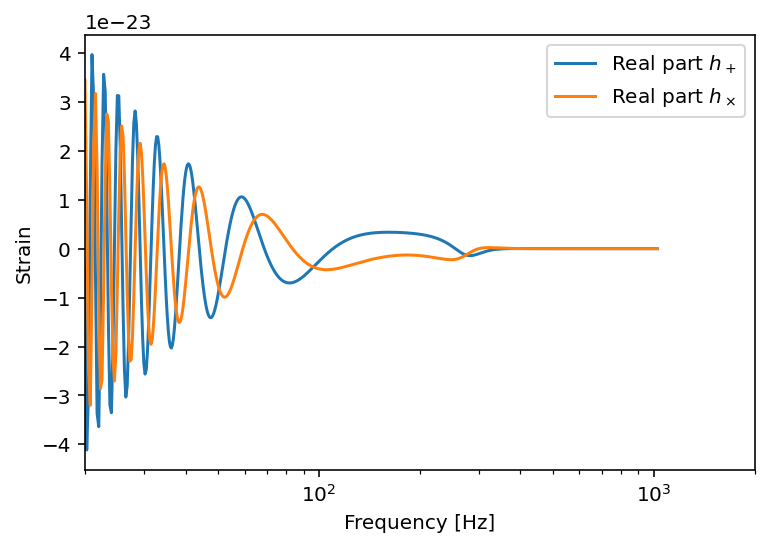

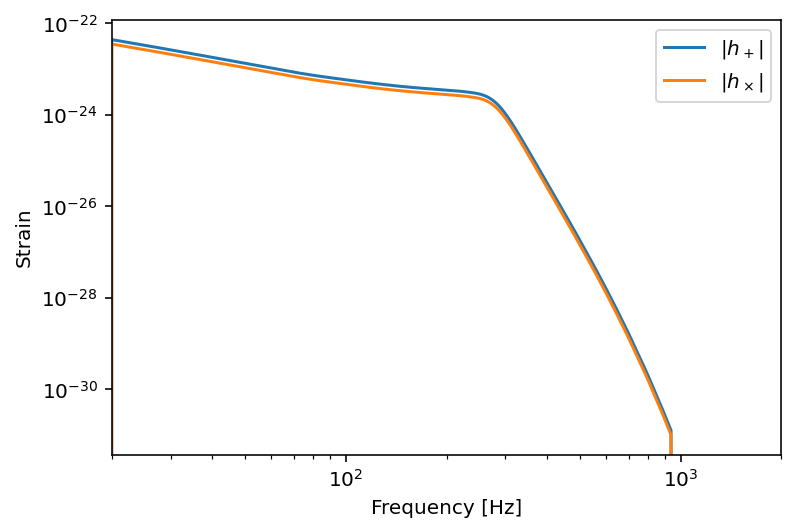

In [5]:
gen_h = waveform_generator.frequency_domain_strain(binary_parameters)
fs = bilby.core.utils.series.create_frequency_series(sampling_frequency,duration)

hp = gen_h['plus']
hx = gen_h['cross']

plt.semilogx(fs,hp,label=r'Real part $h_+$')
plt.plot(fs,hx,label=r'Real part $h_\times$')
plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'Strain')
plt.xlim([20,2e3])
plt.legend()
plt.show()

plt.loglog(fs,abs(hp),label=r'$|h_+|$')
plt.plot(fs,abs(hx),label=r'$|h_\times|$')
plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'Strain')
plt.xlim([20,2e3])
plt.legend()
plt.show()

And the time domain one

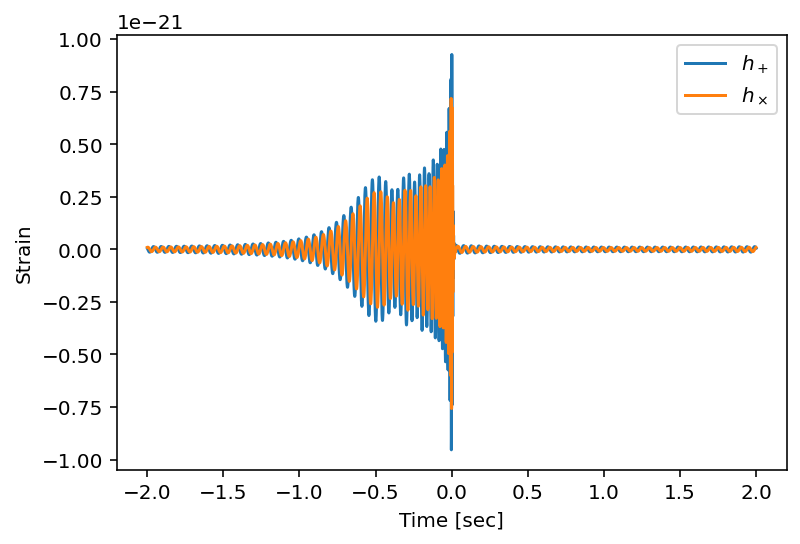

In [6]:
gen_h = waveform_generator.time_domain_strain(binary_parameters)
ts = bilby.core.utils.series.create_time_series(sampling_frequency,duration)


hp = gen_h['plus']
hx = gen_h['cross']

#We reorder the data because the time of coalescence is set at t=0
hp = np.append(hp[ts > duration / 2],hp[ts <= duration / 2])
hx = np.append(hx[ts > duration / 2],hx[ts <= duration / 2])
ts = np.append(ts[ts > duration / 2]-duration,ts[ts <= duration / 2])

plt.plot(ts,hp,label=r'$h_+$')
plt.plot(ts,hx,label=r'$h_\times$')
plt.xlabel(r'Time [sec]')
plt.ylabel(r'Strain')
plt.legend()
plt.show()

---

## To play with

- How does the peak frequency depends on the mass
- How does the ratio of the polarizations depend on inclination
- How does the signal change when you add additional modes, e.g. $[[2,\pm2],[2,\pm1],[3,\pm3],[3,\pm2]],[4,\pm4]$? does this depend in the ratio of the masses?

---
## Antenna functions

The detected signal at a given detector is projected using the antenna patter functions

$$h = F_+h_+ + F_\times h_\times$$

In [7]:
def Fp(RA,DEC,Psi): #(57) of https://arxiv.org/pdf/0903.0338.pdf
    phi = RA
    theta = np.pi/2.0 - DEC
    return 0.5*(1 + np.cos(theta)**2)*np.cos(2*phi)*np.cos(2*Psi) - np.cos(theta)*np.sin(2*phi)*np.sin(2*Psi)

def Fx(RA,DEC,Psi): #(57) of https://arxiv.org/pdf/0903.0338.pdf
    phi = RA
    theta = np.pi/2.0 - DEC
    return 0.5*(1 + np.cos(theta)**2)*np.cos(2*phi)*np.sin(2*Psi) + np.cos(theta)*np.sin(2*phi)*np.cos(2*Psi)

---

## To play with

- What is the sky position with highest detected signal?